In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


2025-06-22 07:03:26.911708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750575807.193831      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750575807.273045      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def extract_emotion_features(filename, fixed_length=130):
    y, sr = librosa.load(filename, duration=4, offset=0)
    # MFCC + Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc = librosa.util.fix_length(mfcc, size=fixed_length, axis=1)

    delta = librosa.feature.delta(mfcc)
    delta = librosa.util.fix_length(delta, size=fixed_length, axis=1)

    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2 = librosa.util.fix_length(delta2, size=fixed_length, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = librosa.util.fix_length(chroma, size=fixed_length, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = librosa.util.fix_length(contrast, size=fixed_length, axis=1)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = librosa.util.fix_length(zcr, size=fixed_length, axis=1)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth = librosa.util.fix_length(bandwidth, size=fixed_length, axis=1)

    # Pitch using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[magnitudes > np.median(magnitudes)]) if np.any(magnitudes > np.median(magnitudes)) else 0
    pitch_feature = np.full((1, fixed_length), pitch)

    # RMS energy
    rms = librosa.feature.rms(y=y)
    rms = librosa.util.fix_length(rms, size=fixed_length, axis=1)

    # Concatenate all features
    combined = np.concatenate((mfcc, delta,delta2, chroma, contrast, zcr, bandwidth, pitch_feature,rms), axis=0)

    return combined.T  # Shape: (time_steps, features)

In [3]:
import os
import pandas as pd

def extract_label_from_filename(filename):
    parts = filename.split('-')
    if len(parts) < 3:
        return None

    modality = int(parts[1])  # 01 = speech, 02 = song
    emotion_code = int(parts[2])

    emotion_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }

    emotion = emotion_map.get(emotion_code)
    if emotion:
        return f"{modality}_{emotion}"
    return None

# Collect unique by filename
seen_filenames = set()
file_paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav') and filename not in seen_filenames:
            label = extract_label_from_filename(filename)
            if label:
                seen_filenames.add(filename)
                path = os.path.join(dirname, filename)
                file_paths.append(path)
                labels.append(label)

# Create DataFrame
df = pd.DataFrame({'audio': file_paths, 'label': labels})
df = df.sort_values(by='label').reset_index(drop=True)

print(df.head())
print(f"Final total unique audio files: {len(df)}")


                                               audio    label
0  /kaggle/input/ravdess-dataset/Audio_Speech_Act...  1_angry
1  /kaggle/input/ravdess-dataset/Audio_Speech_Act...  1_angry
2  /kaggle/input/ravdess-dataset/Audio_Speech_Act...  1_angry
3  /kaggle/input/ravdess-dataset/Audio_Speech_Act...  1_angry
4  /kaggle/input/ravdess-dataset/Audio_Speech_Act...  1_angry
Final total unique audio files: 2452


In [4]:
X_features = [extract_emotion_features(f) for f in df['audio']]
X = np.array(X_features)
print(X.shape)

(2452, 130, 62)


In [5]:
def normalize_features(X):
    # Flatten to 2D
    num_samples, time_steps, num_features = X.shape
    X_flat = X.reshape(-1, num_features)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    joblib.dump(scaler, 'scaler.pkl')

    return X_scaled.reshape(num_samples, time_steps, num_features)

X = normalize_features(X)
print(X.shape)

(2452, 130, 62)


In [6]:


# Encode labels to integers
le = LabelEncoder()
y= le.fit_transform(df['label'])  # Integer labels for class_weight



# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)
# One-hot encode for model training
y = to_categorical(y)
print(le.classes_)

{0: 0.9122023809523809, 1: 0.9122023809523809, 2: 0.9122023809523809, 3: 0.9122023809523809, 4: 0.9122023809523809, 5: 1.8244047619047619, 6: 0.9122023809523809, 7: 0.9122023809523809, 8: 0.9518633540372671, 9: 0.9518633540372671, 10: 0.9518633540372671, 11: 0.9518633540372671, 12: 1.9037267080745341, 13: 0.9518633540372671}
['1_angry' '1_calm' '1_disgust' '1_fearful' '1_happy' '1_neutral' '1_sad'
 '1_surprised' '2_angry' '2_calm' '2_fearful' '2_happy' '2_neutral'
 '2_sad']


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq='epoch'
)
model = Sequential([
    
    
    Conv1D(64, 3, padding='same', activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32,callbacks=[checkpoint_cb])#,class_weight=class_weights)removed due to no improvement

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-22 07:08:20.645314: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.1155 - loss: 3.8017 - val_accuracy: 0.2220 - val_loss: 2.8842
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2332 - loss: 2.8922 - val_accuracy: 0.3218 - val_loss: 2.4159
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.2933 - loss: 2.6040 - val_accuracy: 0.4012 - val_loss: 2.1298
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3325 - loss: 2.3654 - val_accuracy: 0.4297 - val_loss: 2.0238
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3774 - loss: 2.2453 - val_accuracy: 0.5112 - val_loss: 1.8872
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4168 - loss: 2.1138 - val_accuracy: 0.5723 - val_loss: 1.7572
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4781 - loss: 1.9860 - val_accuracy: 0.6029 - val_loss: 1.6480
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4894 - loss: 1.8893 - val_accuracy: 0

In [9]:
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss=np.array(history.history['loss'])
val_loss=np.array(history.history['val_loss'])
avg_loss=(loss+val_loss)/2
avg_acc = (train_acc + val_acc) / 2
best_epoch = np.argmax(avg_acc) + 1  # +1 because epochs start from 1 in filenames

print(f"Best average (acc + val_acc)/2 at epoch {best_epoch},accuracy={train_acc[best_epoch-1]}, validation accuracy={val_acc[best_epoch-1]}, average value = {avg_acc[best_epoch-1]:.4f}")
history.model.load_weights(f"checkpoints/epoch_{best_epoch:02d}.weights.h5")
model.save("kaggle/working/model.h5")

Best average (acc + val_acc)/2 at epoch 190,accuracy=0.9785823822021484, validation accuracy=0.8391038775444031, average value = 0.9088


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
              precision    recall  f1-score   support

     1_angry       0.90      0.92      0.91        39
      1_calm       0.82      0.82      0.82        38
   1_disgust       0.85      0.74      0.79        39
   1_fearful       0.82      0.79      0.81        39
     1_happy       0.93      0.66      0.77        38
   1_neutral       0.45      0.53      0.49        19
       1_sad       0.69      0.71      0.70        38
 1_surprised       0.77      0.97      0.86        38
     2_angry       0.89      0.86      0.88        37
      2_calm       0.95      0.95      0.95        37
   2_fearful       0.85      0.78      0.82        37
     2_happy       0.95      0.97      0.96        37
   2_neutral       1.00      1.00      1.00        18
       2_sad       0.86      0.97      0.91        37

    accuracy                           0.84       491
   macro avg       0.84      0.83      0.83       491
weighted avg       0.84      0.84      0

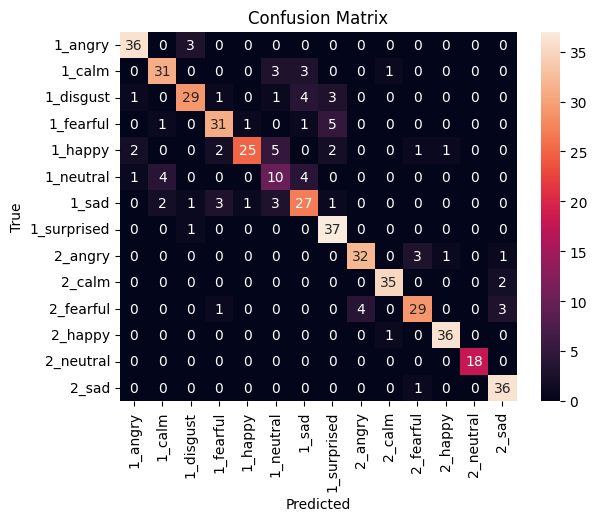

In [10]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
target_names = le.classes_


# Classification report
report =classification_report(y_true, y_pred_labels, target_names=target_names)
print(report)
with open("kaggle/working/classification_report.txt", "w") as f:
    f.write(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("kaggle/working/confusion_matrix.png", dpi=300) 
plt.show()



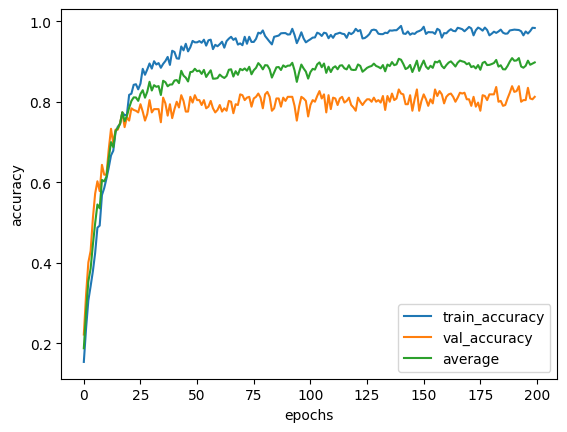

In [11]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.plot(epochs,avg_acc,label='average')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



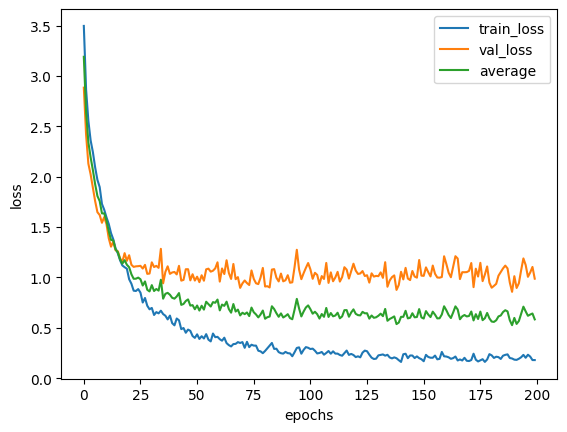

In [12]:


loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.plot(epochs,avg_loss,label='average')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

